## Intuiciones respecto a la relacion entre bias / variance / underfitting y overfitting

Generemos esto con un dataset sintético con una relacion cuadratica entre `x` e `y`

In [1]:
import numpy as np

def sample_data(size=100, x_matrix=False):
    x = (np.random.random(size=size) - 0.5 ) * 5
    x.sort() # util para graficar
    y = x ** 2 + x + np.random.normal(0, 1, size=size)
    if x_matrix:
        x = x.reshape((-1,1))
    return x, y

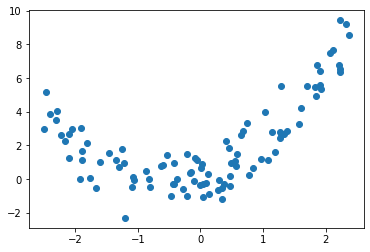

In [2]:
import matplotlib.pyplot as plt

X, y = sample_data(size=100, x_matrix=True)
plt.scatter(X, y)

# Underfitting

Vamos a ajustar esta función cuadratica con una regresion lineal

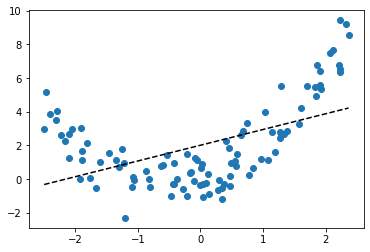

In [3]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X, y)

m, M = X.min(), X.max()

plt.plot([m, M], lr.predict([[m], [M]]), '--k')
plt.scatter(X, y)

Este es un caso típico de underfitting, la capacidad del modelo no es suficiente para explicar los datos

# Fiteamos muchos modelos lineales

Veamos como varian las predicciones si entrenamos muchos modelos lineales.

Podemos ver que el error es sistemáticamente alto

In [4]:
def sample_predictions(model, x, iters=100):
    """
    Toma `iters` muestras de datos, entrena un modelo con esos datos 
    Devuelve el promedio de las predicciones de los modelos
    """
    ys_hat = []
    for _ in range(iters):
        X_train, y_train = sample_data(100, x_matrix=True)
        model.fit(X_train, y_train)
        ys_hat.append(model.predict(x))
    return np.asarray(ys_hat)

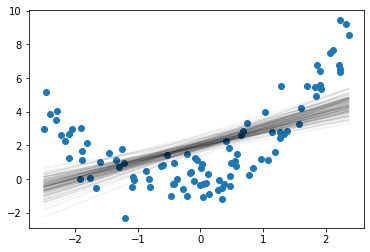

In [5]:
ys = sample_predictions(LinearRegression(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)

# Cambiando regresion lineal por arbol de decisión

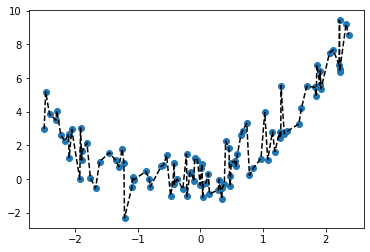

In [6]:
from sklearn.tree import DecisionTreeRegressor

lr = DecisionTreeRegressor().fit(X, y)

plt.plot(X, lr.predict(X), '--k')
plt.scatter(X, y)

Podemos ver como se ajusta a la perfeccion a los datos

# Haciendo muchas predicciones

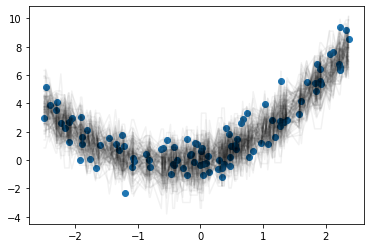

In [7]:
ys = sample_predictions(DecisionTreeRegressor(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)

Podemos ver que al tomar muchas muestras los modelos terminan cubriendo la zona de alta densidad de bolitas

Podemos ver que el modelo esperado se parece mucho a la funcion que genera los datos

In [8]:
def expected_prediction(model, x, iters=100):
    return sample_predictions(model, x, iters=iters).mean(axis=0)

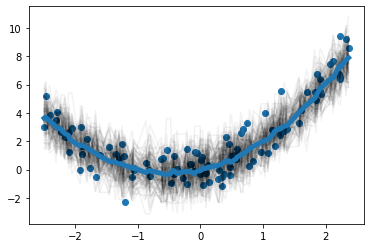

In [9]:
ys = sample_predictions(DecisionTreeRegressor(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)
plt.plot(X, expected_prediction(DecisionTreeRegressor(), X), lw=5)

# Calculando sesgo y varianza

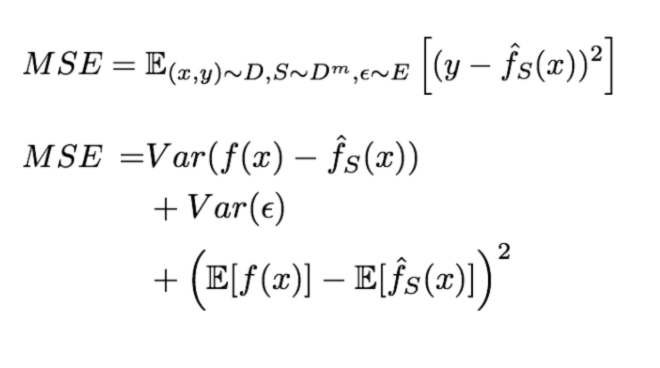

Recordar que en las esperanzas de la segunda ecuacion son sobre las variables que estan en la expresion de MSE.

En este caso, por construccion **sabemos** el valor de `E[f(x)]`.
Es decir `E[f(x)] = x^2 + x` (ver funcion sample_data)

Con eso podemos calcular el sesgo y la varianza para este caso

In [10]:
def bias(model, x, y, iters=100):
    ideal_y = (x**2 + x).squeeze()
    errors = (
        ideal_y - expected_prediction(model, x, iters=iters)
    ) ** 2
    return errors.mean()

def variance(model, x, y, iters=100):
    ideal_y = (x**2 + x).squeeze()
    # repetimos la esperanza en `iters` filas para facilitar el computo
    ideal_y = np.repeat(ideal_y.reshape((1, -1)), iters, axis=0)
    
    # sampleamos iters predicciones de modelos
    ys_hat = sample_predictions(model, x, iters=iters)
    
    # Estimamos la varianza
    return np.var(ideal_y - ys_hat, axis=0).mean()

De esta forma podemos calcular el sesgo y la varianza de una regresion lineal

In [11]:
bias(LinearRegression(), *sample_data(1000, x_matrix=True))

3.7989448358293076

In [12]:
variance(LinearRegression(), *sample_data(1000, x_matrix=True))

0.11026417966175399

Y podemos calcular el sesgo y la varianza de un decision tree

In [13]:
bias(DecisionTreeRegressor(), *sample_data(1000, x_matrix=True), iters=1000)

0.002047796270247959

In [14]:
variance(DecisionTreeRegressor(), *sample_data(1000, x_matrix=True), iters=1000)

1.0174649153798148

Se puede ver que el decision tree tiene **muchisimo menos sesgo**, pero tiene una varianza 10 veces mas alta.